# Simple IO with Embeddings

`topologic` contains extensive `embedding` and `clustering` packages for loading analyzing graphs

## Preconditions
Before we start, you should ensure you have the `matplotlib` library installed.

Below we show an example of how to extract an embedding from a graph.

In [1]:
%config IPCompleter.greedy=True

import networkx as nx
import topologic as tc
import matplotlib.pyplot as plt
import math
import random

# Data
To demonstrate the embedding functioanlity, we are using the network science author graph -- it can be found as a csv file under `test_data/netscience-authors.csv`.

Coauthorships in network science: coauthorship network of scientists working on network theory and experiment, as compiled by M. Newman in May 2006. A figure depicting the largest component of this network can be found here. M. E. J. Newman, Phys. Rev. E 74, 036104 (2006).

In [2]:
# load the graph data
edge_list_path = 'test_data/netscience-authors.csv'

with open(edge_list_path, 'r') as file:
    graph = tc.io.from_file(
        edge_csv_file=file,
        source_column_index=0,
        target_column_index=1,
        weight_column_index=2,
        edge_csv_has_headers=True
    )
    
len(graph.edges())

2742

# Introduction to Embeddings

An embedding is a mapping from an object, such as a word, to a vector in a lower dimensional space. For example, an embedding for words into a 3 dimensional space could look something like:

cat -   [0.015269641674978685,   0.013187535371066428,  0.0031715410923515153]

dog -   [0.014965873253211082,   0.0016122454341539472, 0.0035909807224411283]   

man -   [0.004237593168056164,   0.003526102334225012,  0.0030491193727161248]

woman - [0.0031461043909993824,  0.010022862663402465,  0.040323956479097034]

king -  [0.00013326964708904043, 0.001007046442967896,  6.510123655167899e-05]

queen - [0.0013619392422438148,  0.006342057672591439,  0.002270385097256966]

Embeddings are useful because it allows for the calculation of similarity between two objects. By calculating the cosine or Euclidian distance between two vectors in the embedding, you can determine the similarity between the two objects.

However, we will be generating network embeddings to facilitate the analysis of different graphs. When generating a network embedding, it is best practice to generate an embedding over each individual connected components. In this example, we are going to compute the embedding over the largest connected components.

In [3]:
graph = tc.largest_connected_component(graph)

len(graph.edges())

914

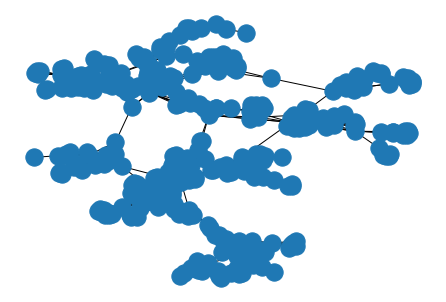

In [4]:
# generate a simple graph layout to visualize the graph using matplotlib.pyplot
layout = nx.spring_layout(graph, k=.5, iterations=500)
nx.draw(graph, pos=layout)
plt.show()

# Generate a laplacian spectral embedding

Generating a laplacian spectral embedding (LSE) is a single method call demonstrated below. `topologic` supports several embedding techniques that can be found in the `embedding` package.

The LSE is created using the eigendecomposition of the Laplacian matrix for a graph. Related, is the `adjacency_embedding` technique which performs the same computation except over the adjacency matrix of a graph.

The result of the embedding is a representation of the graph in an N-dimensional space; each node will have a vector of floats of length N. Since we are setting `maximum_dimensions` to 128, we will compute a LSE for the graph in 128 dimensions.

The return value of `laplacian_embedding` is an `embedding_container` which contains two arrays, one of the embedding and another that contains the vertex labels which are ids of the graph's vertices. A method that is often useful is `embedding_container.to_dictionary()` which will create a dictionary out of your embedding where the keys are vertex ids and the values are the vector for that vertex.

In [5]:
embedding_container = tc.embedding.laplacian_embedding(
    graph=graph,
    maximum_dimensions=128,
    elbow_cut=None # see api documentation for details on elbow cut
)

# will return a dictionary where the keys are node_ids and the values are a vector
embedding_dict = embedding_container.to_dictionary()

print(f'Number of nodes in the graph {len(graph.nodes())} and number of nodes in the embedding {len(embedding_dict.keys())}.')
print(f'The number of dimensions are {len(embedding_container.embedding[0])}.')

Number of nodes in the graph 379 and number of nodes in the embedding 379.
The number of dimensions are 128.


# Applications for the Embedding

Embeddings allow for distances to be computed in the embedded space instead of in the network space. Below, two examples will be shown.

The first is most_similar which will compute the most similar vertex for each vertex in the graph. NOTE: this implementation is naive and will be O(n^2) time complexity.

The second is a kmeans clustering of the nodes in the embedded space. `topologic` has an extensive clustering package in `embedding.clustering` which provides several different clustering techniques. For simple demonstration, kmeans will be used.


#### Comparison of Clustering Techniques

For a comprehensive comparison of different clustering techniques see the sklearn <a href="https://scikit-learn.org/stable/modules/clustering.html">documentation</a>.

In [6]:
# we chose cosine distance to measure the orientation of the vectors rather than the magnitude of the change
def most_similar(embedding_container, vector_index):
    vector = embedding_container.embedding[vector_index]
    cosine_distances = tc.embedding.distance.embedding_distances_from(
        vector, 
        embedding_container, 
        method="cosine"
    )
    most_similar_node_index = -1 
    min_observed_distance = float('inf')
    for i, distance in enumerate(cosine_distances):
        if i != vector_index:
            if distance < min_observed_distance:
                min_observed_distance = distance
                most_similar_node_index = i
    return embedding_container.vertex_labels[most_similar_node_index]

# again, this is a linear operation applied per node -- this will be super slow on large graphs
for i in range(0, len(embedding_container.vertex_labels)):
    print(f"{embedding_container.vertex_labels[i]}'s most similar author is {most_similar(embedding_container, i)}")       

ABEL H's most similar author is ZAKS M
ABERG Y's most similar author is LILJEROS F
ADLER J's most similar author is AHARONY A
AHARONY A's most similar author is ADLER J
ALAVA M's most similar author is KERTESZ J
ALBERT I's most similar author is ALBERT R
ALBERT R's most similar author is KINNEY R
ALEKSIEJUK A's most similar author is FRONCZAK P
ALLARIA E's most similar author is MEUCCI R
ALMAAS E's most similar author is STROUD D
AMANN A's most similar author is CHAVEZ M
AMARAL L's most similar author is TURTSCHI A
ANCELMEYERS L's most similar author is MARTIN M
ANDRADE J's most similar author is AMARAL L
ANTAL T's most similar author is LEYVRAZ F
ARAUJO A's most similar author is COSTA U
ARECCHI F's most similar author is MEUCCI R
ARENAS A's most similar author is DANON L
AYALI A's most similar author is SEGEV R
BAIESI M's most similar author is CORRAL A
BAK P's most similar author is ZALIZNYAK A
BALTHROP J's most similar author is LUSSEAU D
BANAVAR J's most similar author is MITRA M


KORNISS G's most similar author is KOZMA B
KOVACS B's most similar author is MACDONALD P
KOZMA B's most similar author is KORNISS G
KRAPIVSKY P's most similar author is REDNER S
KUJALA J's most similar author is SALMELIN R
KULKARNI R's most similar author is MACDONALD P
KUMAR R's most similar author is MAGHOUL F
KUMAR S's most similar author is TOMKINS A
KUNTZ P's most similar author is GAUTRAIS J
KURTHS J's most similar author is ROSENBLUM M
LAHTINEN J's most similar author is JARISARAMAKI J
LAI Y's most similar author is NISHIKAWA T
LAROSA M's most similar author is FORTUNA L
LATORA V's most similar author is RAPISARDA A
LAWRENCE S's most similar author is FLAKE G
LEE D's most similar author is GHIM C
LEICHT E's most similar author is GHOSHAL G
LEONE M's most similar author is ZECCHINA R
LEYVRAZ F's most similar author is VAZQUEZ F
LILJEROS F's most similar author is EDLING C
LILLO F's most similar author is MANTEGNA R
LINGJIANG K's most similar author is YUSONG T
LIU Z's most simila

In [7]:
clustering = tc.embedding.clustering.kmeans(
    embedding_container.embedding,
    n_clusters=18
)

# print all nodes in cluster 0, the first cluster
cluster_id = 0
for i in range(len(clustering)):
    if clustering[i] == cluster_id:
        print(embedding_container.vertex_labels[i])

EREZ K
ROZENFELD A
SCHWARTZ N


# Visualizing a graph using matplotlib

Another useful technique is to visualize a graph using metrics. `topologic` plays nicely with `networkx` and `matplotlib.pyplot`

Below is an example showing how you can use `topologic` to find the communities of a graph and then use `networkx` and `matplotlib` to render the graph.

In [8]:
communities = tc.partition.louvain(graph)

# use matplotlib to generate a color scheme for each node in the graph using its community
colors = []
for node in graph.nodes():
    colors.append(communities[node])

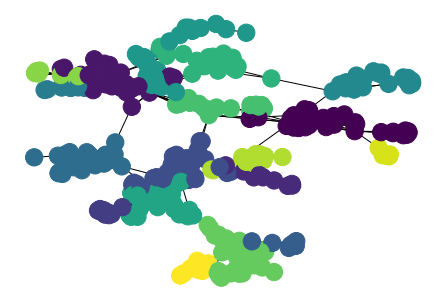

In [9]:
# draw with networkx and render with matplotlib.pyplot
nx.draw(graph, pos=layout, node_color=colors)
plt.show()

# For more information

<a href="https://en.wikipedia.org/wiki/Embedding">Embedding</a>

<a href="https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix">Eigendecompisition</a>

<a href="https://en.wikipedia.org/wiki/Spectral_clustering">Spectral Clustering</a>